Imported Libaries

In [1]:
import os
root_dir = r'c:\Users\jf79\Cloned Repos\Footfall-Repo'
os.chdir(root_dir)

import pandas as pd
import numpy as np

import myfuncs.myfuncs as mf
import myfuncs.footfallfuncs as ff

mf.read_directory()

import warnings
warnings.filterwarnings('ignore')

Your Current Directory is: c:\Users\jf79\Cloned Repos\Footfall-Repo
Files in: ['.git', 'Footfall.venv', 'Footfall_Scripts', 'myfuncs', 'README.md']



Plot Functions Specific to this Script

In [2]:
from matplotlib.pyplot import matplotlib as plt

def plot_footfall(df, df2=None, year=False, category=False, dual_axis=False):
    tf = df.copy()
    if df2 is not None:
        tf2 = df2.copy()
    title = f'Comparison of Normalised Footfall (Monthly MA)'
    if year:
        tf = tf[tf['year'] == year]
        if df2 is not None:
            tf2 = tf2[tf2['year'] == year]
        title = f'{title} ({year})'
    
    if category == 'normalized':
        tf['corrected_normalized'] = tf['corrected_ma_monthly_total']/tf['corrected_ma_monthly_total'].max()
        if df2 is not None:
            tf2['corrected_normalized'] = tf2['corrected_ma_monthly_total']/tf2['corrected_ma_monthly_total'].max()

    if dual_axis:
        fig, ax1 = plt.subplots(figsize=(10, 7))
        ax1.plot(
            tf['count_date'],
            tf[f'corrected_{category}'],
            label='Footfall (London)',
            color='red'
        )
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Footfall Count (London)', color='blue', fontsize=14)
        ax1.tick_params(axis='y', color='blue', labelsize=12)
        ax1.legend(loc='upper left')

        if df2 is not None:
            ax2 = ax1.twinx()  # Create a secondary y-axis
            ax2.plot(
                tf2['count_date'],
                tf2[f'corrected_{category}'],
                label='Footfall (H&F)',
                color='blue'
            )
            ax2.set_ylabel('Footfall Count (H&F)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.legend(loc='upper right')

        plt.title(f'{title}')
        plt.show()

    if category and dual_axis == False:
        plt.figure(figsize=(12,7))

        plt.plot(
            tf['count_date'],
            tf[f'corrected_{category}'],
            label = 'Normalised Footfall (London)',
            color = 'red'
        )

        if df2 is not None:
            plt.plot(
            tf2['count_date'],
            tf2[f'corrected_{category}'],
            label = 'Normalised Footfall (H&F)',
            color = 'blue'
            )
        
        seasons = {
            'Winter':('01-01','03-20','lightblue'),
            'Spring':('03-21','06-20','lightgreen'),
            'Summer':('06-21','09-22','gold'),
            'Autumn':('09-23','12-21','orange'),
            'Christmas':('12-22','12-31','red'),
        }
        if year:
            plot_years = year
            for season, (start_md, end_md, colour) in seasons.items():
                start = f'{year}-{start_md}'
                end = f'{year}-{end_md}'
                plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colour, alpha=0.25, label=season)
        else:
            plot_years = range(2022,2025)         
            for year in plot_years:
                for season, (start_md, end_md, colour) in seasons.items():
                    start = f'{year}-{start_md}'
                    end = f'{year}-{end_md}'
                    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colour, alpha=0.25, label=season)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Normalised Footfall', fontsize=12)
        plt.title(f'{title}', fontsize=16)
        plt.legend(
            by_label.values(),
            by_label.keys(),
            fontsize=9
        )
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlim(
            right = tf['count_date'].max(),
            left = tf['count_date'].min()
        )
        plt.show()

    else:
        print('## Please specify a category ##')

def plot_daily_footfall(df, df2=None, year=False, day_night=False):
    title = f'Comparison of Daytime and Nightime Footfall'
    merge_list = ['day_name']
    tf = df.copy()
    if df2 is not None:
        tf2 = df2.copy()
    if year:
        tf = tf[tf['year'] == year]
        if df2 is not None:
            tf2 = tf2[tf2['year'] == year]
        title = f'{title} ({year})'
    
    if day_night:
        tf = ff.transform_to_daynight(tf)
        if df2 is not None:
            tf2 = ff.transform_to_daynight(tf2)

    # Aggregate data for both datasets and merge them
    aggregated_data = tf.groupby(merge_list).agg(
        Nighttime_mean = ('6pm-6am','mean'),
        Daytime_mean = ('6am-6pm','mean'),
    ).reset_index()
    
    if df2 is not None:
        aggregated_data = pd.merge(
            aggregated_data,
            tf2.groupby(merge_list).agg(
            Nighttime_mean = ('6pm-6am','mean'),
            Daytime_mean = ('6am-6pm','mean'),
            ).reset_index(),
            how='left', on=merge_list,
            suffixes=['_lon', '_lbhf']
        )

    dictionary = {
        'Monday':'0',
        'Tuesday':'1',
        'Wednesday':'2',
        'Thursday':'3',
        'Friday':'4',
        'Saturday':'5',
        'Sunday':'6'
    }
    aggregated_data['day_order'] = aggregated_data['day_name'].map(dictionary)
    aggregated_data = aggregated_data.set_index('day_order').sort_index()
    display(aggregated_data)
    
    # Extract categories and values for plotting
    categories = aggregated_data['day_name'].unique()

    if df2 is not None:
        night1 = aggregated_data['Nighttime_mean_lon']
        day1 = aggregated_data['Daytime_mean_lon']
        night2 = aggregated_data['Nighttime_mean_lbhf']
        day2 = aggregated_data['Daytime_mean_lbhf']
    else:
        night1 = aggregated_data['Nighttime_mean']
        day1 = aggregated_data['Daytime_mean']

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(categories))

    if df2 is not None:
        # Plot daytime and nighttime footfall data
        ax.bar(index, day1, bar_width, label='Daytime Footfall (LDN)', color='skyblue')
        ax.bar([i + bar_width for i in index], night1, bar_width, label='Nighttime Footfall (LDN)', color='blue')
        ax.bar(index, day2, bar_width, label='Daytime Footfall (LBHF)', color='skyblue')
        ax.bar([i + bar_width for i in index], night2, bar_width, label='Nighttime Footfall (LBHF)', color='blue')
    else:
        # Plot daytime and nighttime footfall data
        ax.bar(index, day1, bar_width, label='Daytime Footfall (LBHF)', color='skyblue')
        ax.bar([i + bar_width for i in index], night1, bar_width, label='Nighttime Footfall (LBHF)', color='blue')

    # Set axis labels and title
    ax.set_xlabel("Days of the Week", fontsize=14)
    ax.set_ylabel("Total Footfall", fontsize=14)
    ax.set_title("Comparison of Daytime and Nighttime Footfall (2024)", fontsize=16)
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(aggregated_data['day_name'])
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1_000)}K'))
    ax.tick_params(axis='both', which='major', labelsize=12)
    if df2 is not None:
        ax.set_ylim([min(night2)-(min(night2)*0.1), max(day1) * 1.1])
    else:
        ax.set_ylim([min(night1)-(min(night1)*0.1), max(day1) * 1.1])

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    
def calulcaute_QoQ_values(df):
    df = df.set_index('count_date')
    df = df[['corrected_value_total']]
    quarterly_df = df.resample('Q').mean()
    # Calculate Quarter-over-Quarter (QoQ) percentage change
    quarterly_df['QoQ_change'] = quarterly_df['corrected_value_total'].pct_change() * 100
    # Calculate Year-over-Year (YoY) percentage change, looking back 4 quarters
    quarterly_df['YoY_change'] = quarterly_df['corrected_value_total'].pct_change(periods=4) * 100
    quarterly_df = quarterly_df.round(2)
    display(quarterly_df)
    return quarterly_df

In [3]:
cwd = 'C:/Users/jf79/OneDrive - Office Shared Service/Documents/H&F Analysis/Footfall and Spend Analysis/Footfall Data/Hex Based/Footfall Counts'
os.chdir(cwd)
directory = os.getcwd()
files = os.listdir(os.getcwd())
print(f"Your Current Directory is: {directory}")
print("Files in: %s" % (files))

Your Current Directory is: C:\Users\jf79\OneDrive - Office Shared Service\Documents\H&F Analysis\Footfall and Spend Analysis\Footfall Data\Hex Based\Footfall Counts
Files in: ['BT Hex ID to Borough Lookup Table.csv', 'hex_3hourly_counts_2022.csv', 'hex_3hourly_counts_2023.csv', 'hex_3hourly_counts_2024.csv', 'hex_3hourly_counts_2025.csv']


In [4]:
footfall_data_2022 = pd.read_csv('hex_3hourly_counts_2022.csv')
footfall_data_2023 = pd.read_csv('hex_3hourly_counts_2023.csv')
footfall_data_2024 = pd.read_csv('hex_3hourly_counts_2024.csv')
footfall_data_2025 = pd.read_csv('hex_3hourly_counts_2025.csv')
hex_to_borough_data = pd.read_csv('BT Hex ID to Borough Lookup Table.csv')

In [5]:
footfall_2022 = footfall_data_2022.copy()
footfall_2023 = footfall_data_2023.copy()
footfall_2024 = footfall_data_2024.copy()
footfall_2025 = footfall_data_2025.copy()
hex_to_borough = hex_to_borough_data.copy()

lon_footfall_data = pd.concat([footfall_2022,footfall_2023,footfall_2024,footfall_2025])

lon_footfall_data = pd.merge(lon_footfall_data,hex_to_borough, left_on='hex_id', right_on='Hex_ID', how='left')

In [6]:
lon_footfall_data = lon_footfall_data.drop(
    columns = [
        'Hex_ID','GSS_CODE','day'
    ]
)

columns_to_fill = [
    'resident','visitor','worker'
]
lon_footfall_data.loc[:, columns_to_fill] = lon_footfall_data[columns_to_fill].applymap(lambda x: np.nan if x < 0 else x)
lon_footfall_data[columns_to_fill] = lon_footfall_data[columns_to_fill].fillna(0)
lon_footfall_data[columns_to_fill] = lon_footfall_data[columns_to_fill].astype('uint16')

lon_footfall_data['time_indicator'] = lon_footfall_data['time_indicator'].str.strip("'")
lon_footfall_data['count_date'] = pd.to_datetime(lon_footfall_data['count_date'])
lon_footfall_data['time_indicator'] = lon_footfall_data['time_indicator'].astype('category')

lon_footfall_data.sort_values(by=['count_date','time_indicator','hex_id'], inplace=True)
lon_footfall_data

,hex_id,count_date,time_indicator,resident,visitor,worker,loyalty_percentage,dwell_time,borough_name
0,10631211,2022-05-01,03-06,0,0,0,0.00,121.38,Hillingdon
1428,10641210,2022-05-01,03-06,0,0,0,0.00,120.00,Hillingdon
2846,10641212,2022-05-01,03-06,0,0,0,0.00,87.00,Hillingdon
5370,10641216,2022-05-01,03-06,0,0,0,24.13,128.75,Hillingdon
6712,10641218,2022-05-01,03-06,0,0,0,0.00,145.00,Hillingdon
...,...,...,...,...,...,...,...,...,...
119132111,12521270,2025-02-09,21-24,0,0,0,NaN,180.00,Havering
119132212,12531265,2025-02-09,21-24,14,0,0,NaN,125.00,Havering
119132264,12531267,2025-02-09,21-24,0,0,0,NaN,NaN,Havering
119132351,12531271,2025-02-09,21-24,0,0,0,NaN,NaN,Havering


In [ ]:
lon_footfall_data = ff.agg_footfall_data(
    lon_footfall_data,
    primary_key='hex_id',
    footfall_type=['residents','workers','visitors'],
)

lon_footfall_data

In [7]:
dn_lon_footfall_data = lon_footfall_data.copy()
dn_lbhf_footfall_data = lon_footfall_data.copy()
dn_lbhf_footfall_data = dn_lbhf_footfall_data[dn_lbhf_footfall_data['borough_name'] == 'Hammersmith & Fulham']
print('Data copied')
dn_lon_footfall_data = ff.agg_footfall_data(dn_lon_footfall_data,day_night=True)
dn_lbhf_footfall_data = ff.agg_footfall_data(dn_lbhf_footfall_data,day_night=True)

Data copied

Aggregating footfall data...
Missing kwargs: {'time_indicator', 'footfall_type', 'primary_key', 'agg'}
These args will be set to default values

Applying features...
Features applied.


Detecting anomalies...
Error detecting anomalies: cannot access local variable 'keywords' where it is not associated with a value

Error aggregating footfall data: "None of [Index(['count_date', 'day_name', 'week_name', 'day_night',\n       'corrected_ma_monthly', 'corrected_ma_weekly', 'corrected_value'],\n      dtype='object')] are in the [columns]"


Aggregating footfall data...
Missing kwargs: {'time_indicator', 'footfall_type', 'primary_key', 'agg'}
These args will be set to default values

Applying features...
Features applied.


Detecting anomalies...
Error detecting anomalies: cannot access local variable 'keywords' where it is not associated with a value

Error aggregating footfall data: "None of [Index(['count_date', 'day_name', 'week_name', 'day_night',\n       'corrected_ma_mont

In [8]:
r
agg_lon_footfall_data = lon_footfall_data.copy()
agg_lbhf_footfall_data = lon_footfall_data.copy()
agg_lbhf_footfall_data = agg_lbhf_footfall_data[agg_lbhf_footfall_data['borough_name'] == 'H&F']
print('Data copied')
agg_lon_footfall_data = ff.agg_footfall_data(agg_lon_footfall_data)
agg_lbhf_footfall_data = ff.agg_footfall_data(agg_lbhf_footfall_data)
agg_lon_footfall_data = ff.apply_features(agg_lon_footfall_data)
agg_lbhf_footfall_data = ff.apply_features(agg_lbhf_footfall_data)

NameError: name 'r' is not defined

In [ ]:
plot_footfall(agg_lon_footfall_data, df2=agg_lbhf_footfall_data, category='normalized')

In [ ]:
plot_footfall(agg_lon_footfall_data, df2=agg_lbhf_footfall_data, year=2024, category='normalized')

DataFrame: aggregated_data


,day_name,Nighttime_mean,Daytime_mean
day_order,,,
0,Monday,215529.283019,513647.207547
1,Tuesday,228828.792453,562502.584906
2,Wednesday,236481.942308,569587.519231
3,Thursday,247453.384615,581196.903846
4,Friday,258488.442308,506186.980769
5,Saturday,280208.980769,451722.826923
6,Sunday,204373.365385,367980.115385


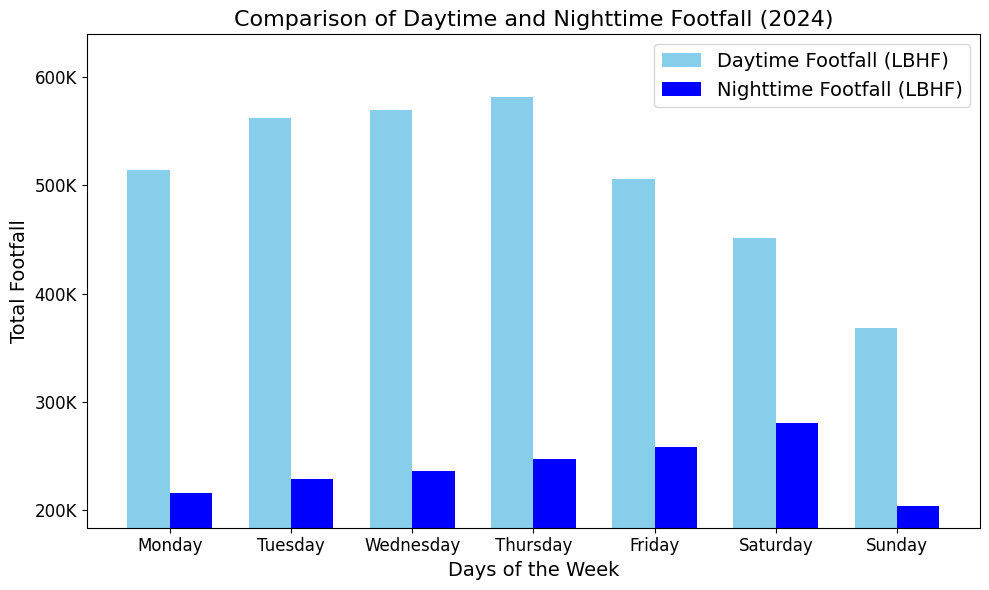

In [ ]:
plot_daily_footfall(dn_lbhf_footfall_data, year=2024, day_night=True)

In [ ]:
calulcaute_QoQ_values(agg_lbhf_footfall_data)
calulcaute_QoQ_values(agg_lon_footfall_data)

DataFrame: quarterly_df


,corrected_value_total,QoQ_change,YoY_change
count_date,,,
2022-06-30,1391054.55,NaN,NaN
2022-09-30,1513581.18,8.81,NaN
2022-12-31,1587138.12,4.86,NaN
2023-03-31,1698746.98,7.03,NaN
2023-06-30,1613787.07,-5.00,16.01
2023-09-30,1456290.61,-9.76,-3.79
2023-12-31,1716552.80,17.87,8.15
2024-03-31,1708876.37,-0.45,0.60
2024-06-30,1729020.89,1.18,7.14


DataFrame: quarterly_df


,corrected_value_total,QoQ_change,YoY_change
count_date,,,
2022-06-30,57044269.01,NaN,NaN
2022-09-30,61715690.01,8.19,NaN
2022-12-31,65092744.77,5.47,NaN
2023-03-31,68271960.38,4.88,NaN
2023-06-30,64272145.13,-5.86,12.67
2023-09-30,57877947.82,-9.95,-6.22
2023-12-31,71507561.90,23.55,9.85
2024-03-31,71652527.86,0.20,4.95
2024-06-30,71738124.13,0.12,11.62


,corrected_value_total,QoQ_change,YoY_change
count_date,,,
2022-06-30,57044269.01,NaN,NaN
2022-09-30,61715690.01,8.19,NaN
2022-12-31,65092744.77,5.47,NaN
2023-03-31,68271960.38,4.88,NaN
2023-06-30,64272145.13,-5.86,12.67
2023-09-30,57877947.82,-9.95,-6.22
2023-12-31,71507561.90,23.55,9.85
2024-03-31,71652527.86,0.20,4.95
2024-06-30,71738124.13,0.12,11.62
